## Summary of the journal used for the implementation
### Paper's objectives:
- Improve the classification accuracy of histopathological images for lung and colon cancer using deep learning techniques.
- Utilize transfer learning and ensemble learning to enhance the classification performance of three pre-trained CNN models: VGG-16, ResNet-50, and DenseNet.
- Demonstrate that combining multiple models can improve classification results for cancer detection.

### Methodologies/Algorithm implemented:
- #### Transfer learning - CNN:
    - Uses pre-trained models VGG-16, ResNet-50, and DenseNet to extract features from histopathological images.
- #### Ensemble Learning:
    - Averages predictions from VGG-16, ResNet-50, and DenseNet models to create a final ensemble model.
- #### Dataset Preprocessing:
    - The dataset was split into 80% training, 10% validation, and 10% testing.
    - Images were resized and normalized before training. 


### Significance of the study
- Ensemble model provides a more reliable diagnosis compared to individual deep learning models.
- Automating cancer detection can assist medical professionals in early diagnosis, improving survival rates.

# 1. Import the required libraries

In [17]:
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet121
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import os

# 2. Data Acquisition
 
For the problem identified by you, students have to find the data source themselves from any data source.

Provide the URL of the data used.

Write Code for converting the above downloaded data into a form suitable for DL



In [18]:
##---------Type the code below this line------------------##
data_url="https://www.kaggle.com/datasets/andrewmvd/lung-and-colon-cancer-histopathological-images"

dataset_path = "C:/Users/samulya/Desktop/lung_colon_image_set"

# 3. Data Preparation

Perform the data prepracessing that is required for the data that you have downloaded. 


This stage depends on the dataset that is used. 

In [19]:
##---------Type the code below this line------------------##
img_size = (224, 224)  # Resize images to 224x224 for pre-trained models
batch_size = 32

#Dividing into training and validation datasets
train_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="training",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)

val_dataset = tf.keras.utils.image_dataset_from_directory(
    dataset_path,
    validation_split=0.2,
    subset="validation",
    seed=42,
    image_size=img_size,
    batch_size=batch_size,
    label_mode='categorical'
)


Found 25000 files belonging to 2 classes.
Using 20000 files for training.
Found 25000 files belonging to 2 classes.
Using 5000 files for validation.


In [20]:
# Normalize the data (rescale to [0, 1])
normalization_layer = tf.keras.layers.Rescaling(1.0 / 255.0)
train_dataset = train_dataset.map(lambda x, y: (normalization_layer(x), y))
val_dataset = val_dataset.map(lambda x, y: (normalization_layer(x), y))

In [22]:
## Split the data into training set and testing set
##---------Type the code below this line------------------##
train_datagen = ImageDataGenerator(
    rescale=1.0 / 255.0,  # Normalize pixel values to [0, 1]
    rotation_range=20,  # Data augmentation
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    validation_split=0.2  # 20% of data for validation
)

# Load training data
train_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='training'  # Use 80% of data for training
)

# Load validation data
val_generator = train_datagen.flow_from_directory(
    dataset_path,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation'  # Use 20% of data for validation
)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


## 4. Deep Neural Network Architecture


## 4.1 Design the architecture that you will be using

* CNN / RNN / Transformer as per the journal referenced



According to the journal referenced, we use pre-trained models such as VGG16, Resnet50 and DenseNet 121.

The build_model function is designed to fine-tune pre-trained models. It freezes the base model's layers to retain pre-trained feature extraction capabilities and adds new dense layers (512, 256 neurons) with dropout to prevent overfitting. The final softmax layer outputs probabilities for the 5 classes, accordingly to the dataset's structure.



In [23]:
##---------Type the code below this line------------------##

def build_model(base_model, input_shape, num_classes):
    model = models.Sequential()
    model.add(base_model)
    model.add(layers.GlobalAveragePooling2D())
    model.add(layers.Dense(512, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.5))  # Dropout
    model.add(layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.001)))  # L2 regularization
    model.add(layers.Dropout(0.5))  # Dropout
    model.add(layers.Dense(num_classes, activation='softmax'))
    return model

In [24]:
# Load pre-trained models
input_shape = (img_size[0], img_size[1], 3)
num_classes = train_generator.num_classes  # Number of classes (5 in this dataset)

# VGG16
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=input_shape)
vgg16_base.trainable = False  # Freeze the base model
vgg16_model = build_model(vgg16_base, input_shape, num_classes)

# ResNet50
resnet50_base = ResNet50(weights='imagenet', include_top=False, input_shape=input_shape)
resnet50_base.trainable = False  # Freeze the base model
resnet50_model = build_model(resnet50_base, input_shape, num_classes)

# DenseNet121
densenet121_base = DenseNet121(weights='imagenet', include_top=False, input_shape=input_shape)
densenet121_base.trainable = False  # Freeze the base model
densenet121_model = build_model(densenet121_base, input_shape, num_classes)

In [26]:
# 4.2 Compile the models
vgg16_model.compile(optimizer=Adam(learning_rate=0.01, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
resnet50_model.compile(optimizer=Adam(learning_rate=0.01, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])
densenet121_model.compile(optimizer=Adam(learning_rate=0.01, clipvalue=1.0), loss='categorical_crossentropy', metrics=['accuracy'])

## 4.2 DNN Report

Report the following and provide justification for the same.

* Number of layers
* Number of units in each layer
* Total number of trainable parameters 



In [27]:
##---------Type the answer below this line------------------##
# 4.2 Print model summaries
print("VGG16 Model Summary:")
vgg16_model.summary()

print("\nResNet50 Model Summary:")
resnet50_model.summary()

print("\nDenseNet121 Model Summary:")
densenet121_model.summary()

VGG16 Model Summary:


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_2           │ (None, 512)                 │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         262,656 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 15,109,186 (57.64 MB)

 Trainable params: 394,498 (1.50 MB)

 Non-trainable params: 14,714,688 (56.13 MB)


ResNet50 Model Summary:


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)                │ (None, 7, 7, 2048)          │      23,587,712 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_3           │ (None, 2048)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 512)                 │       1,049,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 24,768,642 (94.48 MB)

 Trainable params: 1,180,930 (4.50 MB)

 Non-trainable params: 23,587,712 (89.98 MB)


DenseNet121 Model Summary:


Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_4           │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,694,146 (29.35 MB)

 Trainable params: 656,642 (2.50 MB)

 Non-trainable params: 7,037,504 (26.85 MB)

# 5. Training the model 


In [29]:
# Configure the training, by using appropriate optimizers, regularizations and loss functions
##---------Type the code below this line------------------##
epochs = 10
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,  # Stop after 3 epochs without improvement
    restore_best_weights=True  # Restore the best model weights
)
# Train VGG16
vgg16_history = vgg16_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2306s 4s/step - accuracy: 0.9094 - loss: 0.4715 - val_accuracy: 0.9854 - val_loss: 0.1140
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2304s 4s/step - accuracy: 0.9173 - loss: 0.2836 - val_accuracy: 0.9824 - val_loss: 0.1138
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2343s 4s/step - accuracy: 0.9250 - loss: 0.2671 - val_accuracy: 0.9868 - val_loss: 0.1716
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2300s 4s/step - accuracy: 0.9159 - loss: 0.2629 - val_accuracy: 0.9672 - val_loss: 0.1650
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2246s 4s/step - accuracy: 0.8797 - loss: 0.2836 - val_accuracy: 0.9890 - val_loss: 0.0965
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2216s 4s/step - accuracy: 0.8730 - loss: 0.3023 - val_accuracy: 0.9880 - val_loss: 0.1437
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2210s 4s/step - accuracy: 0.8821 - loss: 0.2930 - val_accuracy: 0.9790 - val_loss: 0.1238
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 2211s 4s/step - accuracy: 0.8590 - loss: 0.3282 - 

In [30]:
# Train ResNet50
resnet50_history = resnet50_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 822s 1s/step - accuracy: 0.5802 - loss: 1.1292 - val_accuracy: 0.6136 - val_loss: 0.6785
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 815s 1s/step - accuracy: 0.5939 - loss: 0.6822 - val_accuracy: 0.6136 - val_loss: 0.6698
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 853s 1s/step - accuracy: 0.5940 - loss: 0.6764 - val_accuracy: 0.6136 - val_loss: 0.6684
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 868s 1s/step - accuracy: 0.5951 - loss: 0.6752 - val_accuracy: 0.6136 - val_loss: 0.6690
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 836s 1s/step - accuracy: 0.5949 - loss: 0.6753 - val_accuracy: 0.6136 - val_loss: 0.6684
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 860s 1s/step - accuracy: 0.5943 - loss: 0.6755 - val_accuracy: 0.6136 - val_loss: 0.6685


In [32]:
# Train DenseNet121
densenet121_history = densenet121_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=epochs,
    callbacks=[early_stopping]
)

Epoch 1/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 823s 1s/step - accuracy: 0.9484 - loss: 0.2011 - val_accuracy: 0.9894 - val_loss: 0.0957
Epoch 2/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 803s 1s/step - accuracy: 0.8756 - loss: 0.2777 - val_accuracy: 0.9800 - val_loss: 0.1037
Epoch 3/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 806s 1s/step - accuracy: 0.8436 - loss: 0.3127 - val_accuracy: 0.9862 - val_loss: 0.1256
Epoch 4/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 865s 1s/step - accuracy: 0.8379 - loss: 0.3080 - val_accuracy: 0.9954 - val_loss: 0.0635
Epoch 5/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 807s 1s/step - accuracy: 0.8443 - loss: 0.3071 - val_accuracy: 0.9960 - val_loss: 0.0540
Epoch 6/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 809s 1s/step - accuracy: 0.8329 - loss: 0.3154 - val_accuracy: 0.9780 - val_loss: 0.0763
Epoch 7/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 815s 1s/step - accuracy: 0.8376 - loss: 0.3126 - val_accuracy: 0.9950 - val_loss: 0.0521
Epoch 8/10
625/625 ━━━━━━━━━━━━━━━━━━━━ 803s 1s/step - accuracy: 0.8320 - loss: 0.3235 - val_accu

# 6. Test the model


In [48]:
import numpy as np
from tensorflow.keras.losses import CategoricalCrossentropy

# Define weights based on validation accuracy (example weights)
weights = {
    'vgg16': 0.3,  # Lower weight for VGG16
    'resnet50': 0.2,  # Moderate weight for ResNet50
    'densenet121': 0.5  # Higher weight for DenseNet121
}

# Function to perform weighted averaging of predictions
def weighted_ensemble_predict(models, weights, x):
    predictions = [model.predict(x) * weight for model, weight in zip(models, weights.values())]
    # Combine predictions using weighted averaging
    weighted_predictions = np.sum(predictions, axis=0)
    return weighted_predictions

val_images, val_true_labels = next(val_generator)

# Get weighted ensemble predictions
weighted_ensemble_pred = weighted_ensemble_predict(
    [vgg16_model, resnet50_model, densenet121_model],  # List of models
    weights,  # Dictionary of weights
    val_images  # Input data
)

# Convert predictions to class labels
weighted_ensemble_pred_classes = np.argmax(weighted_ensemble_pred, axis=1)
val_true_classes = np.argmax(val_true_labels, axis=1)  # Convert one-hot encoded labels to class indices

# Calculate the ensemble model's accuracy
ensemble_accuracy = np.mean(weighted_ensemble_pred_classes == val_true_classes)

# Calculate the ensemble model's loss
loss_fn = CategoricalCrossentropy()  # Use categorical crossentropy for multi-class classification
ensemble_loss = loss_fn(val_true_labels, weighted_ensemble_pred).numpy()

# Print the ensemble model's accuracy and loss
print(f"Weighted Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print(f"Weighted Ensemble Model Loss: {ensemble_loss:.4f}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 913ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 958ms/step
Weighted Ensemble Model Accuracy: 0.9688
Weighted Ensemble Model Loss: 0.1875


# 7. Report the result

1. Plot the training and validation accuracy history.
2. Plot the training and validation loss history. 
3. Report the testing accuracy and loss.
4. Show Confusion Matrix for testing dataset.
5. Report values for preformance study metrics like accuracy, precision, recall, F1 Score.


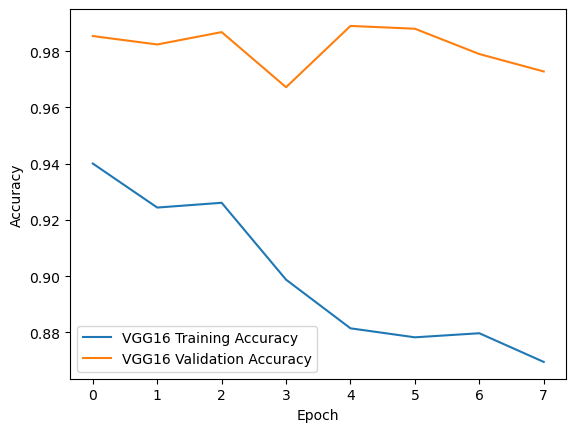

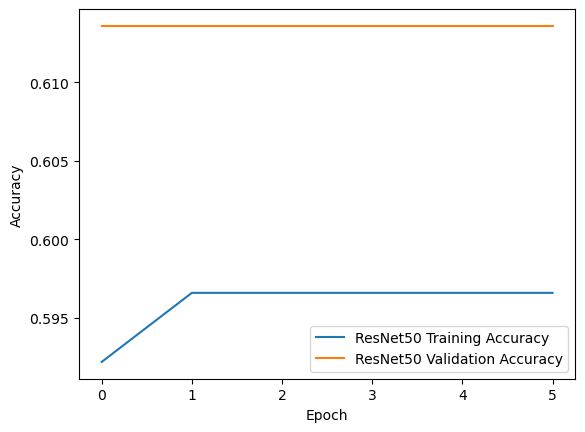

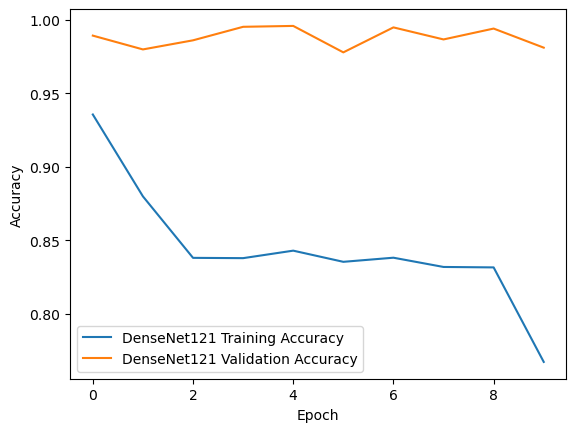

In [49]:
# 1. Plot the training and validation accuracy history for each model
def plot_history(history, model_name):
    plt.plot(history.history['accuracy'], label=f'{model_name} Training Accuracy')
    plt.plot(history.history['val_accuracy'], label=f'{model_name} Validation Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_history(vgg16_history, 'VGG16')
plot_history(resnet50_history, 'ResNet50')
plot_history(densenet121_history, 'DenseNet121')

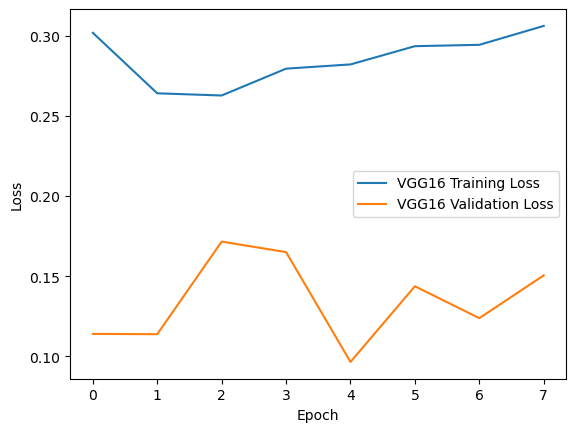

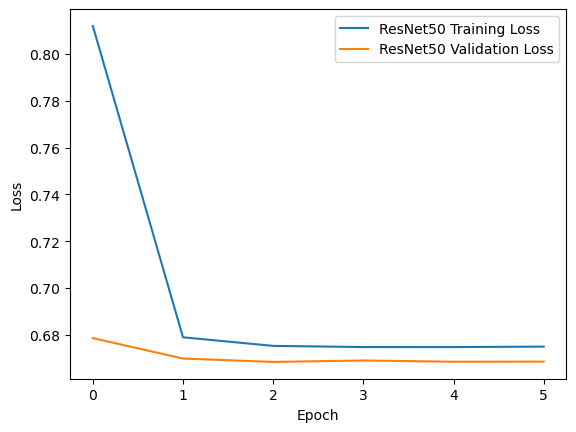

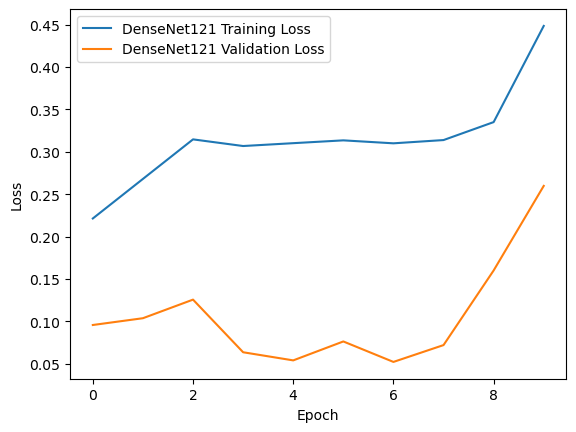

In [50]:
# 2. Plot the training and validation loss history for each model
def plot_loss(history, model_name):
    plt.plot(history.history['loss'], label=f'{model_name} Training Loss')
    plt.plot(history.history['val_loss'], label=f'{model_name} Validation Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(vgg16_history, 'VGG16')
plot_loss(resnet50_history, 'ResNet50')
plot_loss(densenet121_history, 'DenseNet121')

In [51]:
# Print the ensemble model's accuracy and loss
print(f"Weighted Ensemble Model Accuracy: {ensemble_accuracy:.4f}")
print(f"Weighted Ensemble Model Loss: {ensemble_loss:.4f}")

Weighted Ensemble Model Accuracy: 0.9688
Weighted Ensemble Model Loss: 0.1875


In [53]:
# 4. Show Confusion Matrix for the ensemble model
conf_matrix = confusion_matrix(val_true_classes, weighted_ensemble_pred_classes)
print("Confusion Matrix:")
print(conf_matrix)

Confusion Matrix:
[[11  1]
 [ 0 20]]


In [55]:
# 5. Report values for performance study metrics like accuracy, precision, recall, F1 Score
print("Classification Report:")
print(classification_report(val_true_classes, weighted_ensemble_pred_classes, target_names=list(train_generator.class_indices.keys())))

Classification Report:
                  precision    recall  f1-score   support

colon_image_sets       1.00      0.92      0.96        12
 lung_image_sets       0.95      1.00      0.98        20

        accuracy                           0.97        32
       macro avg       0.98      0.96      0.97        32
    weighted avg       0.97      0.97      0.97        32

